# Map Plot from Paper #

2024-11-21 21:25:37,513 - INFO - Node for drug 'Reslizumab' found with average rating: 0.042
2024-11-21 21:25:37,527 - INFO - Node for drug 'Lisuride' found with average rating: 0.47700000000000004
2024-11-21 21:25:37,539 - INFO - Node for drug 'AN-9' found with average rating: 0.471
2024-11-21 21:25:37,586 - INFO - Node for drug 'Rhein' found with average rating: 0.6849999999999999
2024-11-21 21:25:37,614 - INFO - Node for drug 'Oregovomab' found with average rating: 0.265
2024-11-21 21:25:37,628 - INFO - Node for drug '2-deoxyglucose' found with average rating: 0.58
2024-11-21 21:25:37,642 - ERROR - Node for drug 'Thyroid porcine' not found in Neo4j or has no valid ratings.
2024-11-21 21:25:37,653 - INFO - Node for drug 'AR-9281' found with average rating: 0.565
2024-11-21 21:25:37,665 - INFO - Node for drug 'Olokizumab' found with average rating: 0.62
2024-11-21 21:25:37,679 - INFO - Node for drug 'Imiquimod' found with average rating: 0.8150000000000001
2024-11-21 21:25:37,693 - IN

Plot will be saved in: /Users/ricoandreschmitt/Code/GitHub/allmzheimer/plot_creation_pub/map_plot


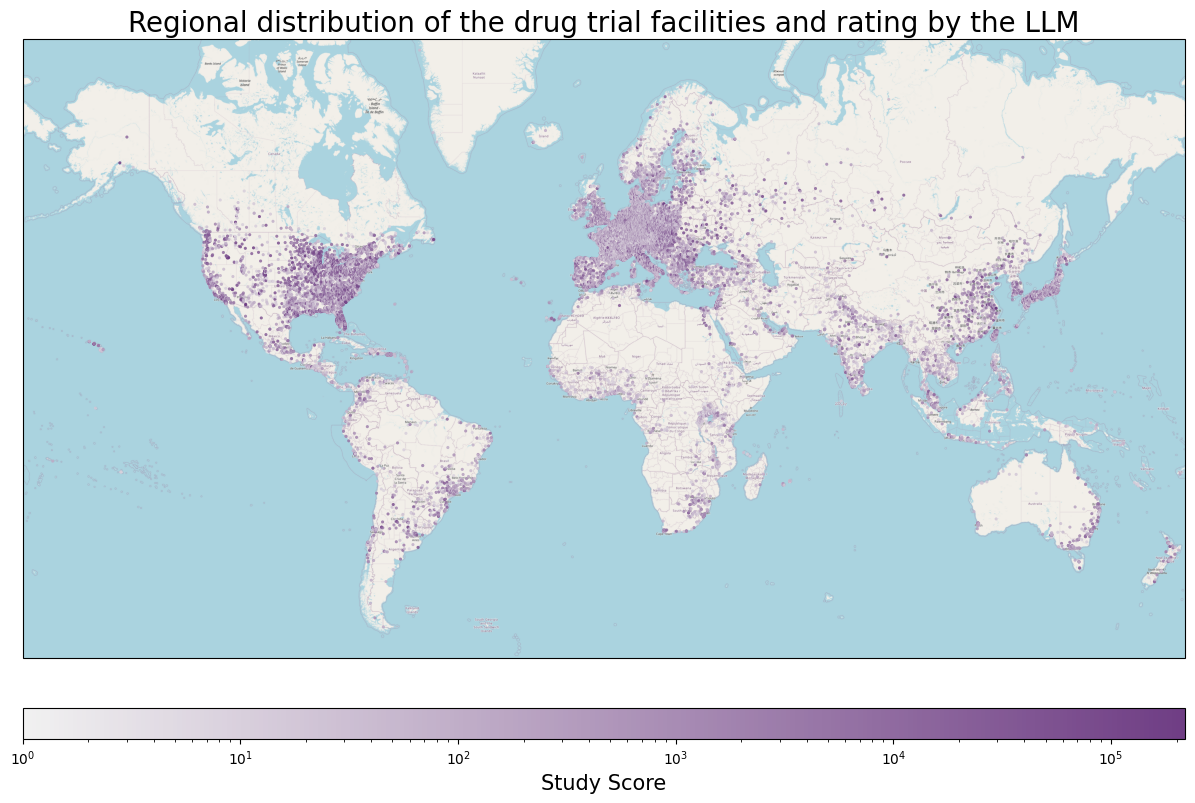

In [12]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from matplotlib.axes import Axes
from neo4j import GraphDatabase
from dotenv import load_dotenv
import logging
from matplotlib.colors import LinearSegmentedColormap

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.FileHandler("script.log"), logging.StreamHandler()]
)

def extract_coordinates(data, weight):
    # (Function code remains unchanged)
    coordinates = []
    if isinstance(data, dict):
        locations = data.get('protocolSection', {}).get('contactsLocationsModule', {}).get('locations', [])
        for location in locations:
            geo_point = location.get('geoPoint', {})
            lat = geo_point.get('lat')
            lon = geo_point.get('lon')
            if lat is not None and lon is not None:
                coordinates.extend([(lon, lat)] * weight)
    elif isinstance(data, list):
        for item in data:
            if isinstance(item, dict):
                coordinates.extend(extract_coordinates(item, weight))
    return coordinates

def sanitize_filename(name):
    return name.replace(' ', '_')

def unsanitize_filename(filename):
    return filename.replace('_', ' ').replace('.json', '')

def get_rating_from_neo4j(uri, user, password, drug_name):
    # (Function code remains unchanged)
    driver = GraphDatabase.driver(uri, auth=(user, password))
    query = """
        MATCH (n:Drug {name: $name})
        RETURN n.rating_0 AS rating_0, n.rating_1 AS rating_1, n.rating_2 AS rating_2,
               n.rating_3 AS rating_3, n.rating_4 AS rating_4, n.rating_5 AS rating_5,
               n.rating_6 AS rating_6, n.rating_7 AS rating_7, n.rating_8 AS rating_8,
               n.rating_9 AS rating_9
    """
    average_rating = None

    with driver.session() as session:
        result = session.run(query, name=drug_name)
        record = result.single()
        if record:
            ratings = [record[f'rating_{i}'] for i in range(10)]
            ratings = [r for r in ratings if r is not None]
            if ratings:
                average_rating = sum(ratings) / len(ratings)

    driver.close()
    return average_rating

def main():
    # Load environment variables
    load_dotenv()
    uri = "bolt://localhost:7690"
    username = os.getenv("username")
    password = os.getenv("password")

    # Directory containing the JSON files
    json_directory = "/Users/ricoandreschmitt/Code/GitHub/allmzheimer/clinical_trials_data/clinical_trials_data_1"



    # List to hold all the coordinates
    all_coordinates = []
    missing_nodes_count = 0
    found_nodes_count = 0

    # Iterate over all JSON files in the directory
    for filename in os.listdir(json_directory):
        if filename.endswith('.json'):
            filepath = os.path.join(json_directory, filename)
            with open(filepath, 'r') as file:
                try:
                    data = json.load(file)
                    drug_name = unsanitize_filename(filename)
                    average_rating = get_rating_from_neo4j(uri, username, password, drug_name)
                    if average_rating is None:
                        missing_nodes_count += 1
                        logging.error(f"Node for drug '{drug_name}' not found in Neo4j or has no valid ratings.")
                        continue
                    found_nodes_count += 1
                    logging.info(f"Node for drug '{drug_name}' found with average rating: {average_rating}")
                    weighted_score = int(1 * average_rating * 10)
                    coordinates = extract_coordinates(data, weighted_score)
                    all_coordinates.extend(coordinates)
                except json.JSONDecodeError as e:
                    logging.error(f"Error decoding JSON from file {filename}: {e}")
                except Exception as e:
                    logging.error(f"Unexpected error processing file {filename}: {e}")

    logging.info(f"Total found nodes: {found_nodes_count}")
    logging.critical(f"Total missing nodes: {missing_nodes_count}")

    # Create a DataFrame from the coordinates
    df = pd.DataFrame(all_coordinates, columns=['Longitude', 'Latitude'])

    # Group by coordinates and get counts
    df_counts = df.groupby(['Longitude', 'Latitude']).size().reset_index(name='Counts')

    # Use OpenStreetMap tiles
    tiler = cimgt.OSM()
    mercator = tiler.crs

    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection=mercator)
    plt.title("Regional distribution of the drug trial facilities and rating by the LLM", fontsize=20)

    # Adjust latitude range to remove the poles
    ax.set_extent([-180, 180, -60, 75], crs=ccrs.PlateCarree())
    ax.add_image(tiler, 4)  # Adjust the zoom level as needed

    cmap = LinearSegmentedColormap.from_list("blue_to_purple", ["#EEE", "#4B0D66"])
    

    # Logarithmic normalization
    norm = mcolors.LogNorm()

    # Plot the points with smaller dots and remove marker edges
    scatter = ax.scatter(
        df_counts['Longitude'],
        df_counts['Latitude'],
        c=df_counts['Counts'],
        cmap=cmap,
        norm=norm,
        s=5,
        alpha=0.8,
        marker='o',
        edgecolors='none',
        linewidths=0,
        transform=ccrs.PlateCarree()
    )

    # Adjust the colorbar to be horizontal and placed below the map
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.5, axes_class=Axes)
    cb = fig.colorbar(scatter, cax=cax, orientation='horizontal')
    label_font = ax.xaxis.label.get_fontproperties()
    cb.set_label('Study Score', fontproperties=label_font, fontsize=15)
    cb.ax.xaxis.set_label_position('bottom')
    cb.ax.xaxis.set_ticks_position('bottom')

    # Save the plot
    print(f"Plot will be saved in: {os.getcwd()}")
    output_file = 'map_with_horizontal_colorbar.png'  
    plt.savefig(output_file, bbox_inches='tight', dpi=1200)
    plt.show()
    plt.close()

if __name__ == "__main__":
    main()

